# DATA PREPROCESSING AN USER PROFILING

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.cluster import KMeans
from river import drift

In [2]:
# Load the datasets
users_df = pd.read_csv('users.csv')
utterances_df = pd.read_csv('utterances.csv')
errors_df = pd.read_csv('errors.csv')
exercises_df = pd.read_csv('exercises.csv')
user_progress_df = pd.read_csv('user_progress.csv')

# 1.1 Feature Engineering

# Combine relevant features
def combine_features(users_df, utterances_df, errors_df, exercises_df, user_progress_df):
    # Merge dataframes based on user_id
    combined_df = users_df.merge(utterances_df.groupby('user_id').agg({
        'grammar_overall_score': 'mean',
        'vocabulary_overall_score': 'mean',
        'pronunciation_overall_score': 'mean',
        'fluency_overall_score': 'mean'
    }), on='user_id', how='left')
    
    # Add error frequencies
    error_freq = errors_df.groupby(['user_id', 'category']).size().unstack(fill_value=0)
    error_freq.columns = [f'error_freq_{col}' for col in error_freq.columns]
    combined_df = combined_df.merge(error_freq, on='user_id', how='left')
    
    # Add exercise performance
    exercise_perf = exercises_df.groupby('user_id')['performance_score'].mean().reset_index()
    combined_df = combined_df.merge(exercise_perf, on='user_id', how='left')
    
    # Add user progress features
    combined_df = combined_df.merge(user_progress_df, on='user_id', how='left')
    
    return combined_df

combined_df = combine_features(users_df, utterances_df, errors_df, exercises_df, user_progress_df)

# Create aggregate features
def create_aggregate_features(combined_df, utterances_df, exercises_df):
    # Error frequency per category and subcategory
    error_freq = errors_df.groupby(['user_id', 'category', 'subcategory']).size().unstack(fill_value=0)
    error_freq.columns = [f'error_freq_{col[0]}_{col[1]}' for col in error_freq.columns]
    combined_df = combined_df.merge(error_freq, on='user_id', how='left')
    
    # Moving averages of performance scores
    performance_ma = exercises_df.groupby('user_id')['performance_score'].rolling(window=5).mean().reset_index()
    performance_ma = performance_ma.groupby('user_id')['performance_score'].last().reset_index()
    performance_ma.columns = ['user_id', 'performance_score_ma']
    combined_df = combined_df.merge(performance_ma, on='user_id', how='left')
    
    # User engagement metrics
    engagement_metrics = utterances_df.groupby('user_id').agg({
        'timestamp': lambda x: (pd.to_datetime(x.max()) - pd.to_datetime(x.min())).days,
        'utterance_id': 'count'
    }).reset_index()
    engagement_metrics.columns = ['user_id', 'days_active', 'total_utterances']
    engagement_metrics['sessions_per_week'] = engagement_metrics['total_utterances'] / (engagement_metrics['days_active'] / 7)
    combined_df = combined_df.merge(engagement_metrics, on='user_id', how='left')
    
    return combined_df

combined_df = create_aggregate_features(combined_df, utterances_df, exercises_df)
combined_df

combined_df.to_csv('combined_features.csv', index=False)

In [3]:
# 1.2 Normalization and Scaling

# Identify numerical and categorical columns
numerical_columns = combined_df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = combined_df.select_dtypes(include=['object']).columns

# Apply min-max scaling to numerical features
scaler = MinMaxScaler()
combined_df[numerical_columns] = scaler.fit_transform(combined_df[numerical_columns])

# One-hot encode categorical variables
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_categorical = encoder.fit_transform(combined_df[categorical_columns])
encoded_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_columns))

# Combine scaled numerical and encoded categorical features
preprocessed_df = pd.concat([combined_df[numerical_columns], encoded_df], axis=1)

preprocessed_df


,overall_progress,total_practice_time,exercises_completed,daily_active_days,weekly_active_days,total_sessions,avg_session_duration,adaptive_difficulty,engagement_score_x,grammar_overall_score,...,"recent_grammar_errors_['preposition_usage', 'subject_verb_agreement']",recent_grammar_errors_['preposition_usage'],"recent_grammar_errors_['subject_verb_agreement', 'article_usage']","recent_grammar_errors_['subject_verb_agreement', 'preposition_usage']","recent_grammar_errors_['subject_verb_agreement', 'tense_usage']",recent_grammar_errors_['subject_verb_agreement'],"recent_grammar_errors_['tense_usage', 'article_usage']","recent_grammar_errors_['tense_usage', 'preposition_usage']",recent_grammar_errors_['tense_usage'],recent_grammar_errors_[]
0,0.858349,0.045302,0.601340,0.500000,0.857143,0.839080,0.28,0.842103,0.711067,0.337504,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.858349,0.045302,0.601340,0.500000,0.857143,0.839080,0.28,0.842103,0.711067,0.337504,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.858349,0.045302,0.601340,0.500000,0.857143,0.839080,0.28,0.842103,0.711067,0.337504,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.858349,0.045302,0.601340,0.500000,0.857143,0.839080,0.28,0.842103,0.711067,0.337504,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.823235,0.620470,0.631491,0.266667,0.714286,0.701149,0.44,0.144421,0.633293,0.507980,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.565653,0.850000,0.904523,0.300000,0.142857,0.919540,0.44,0.221068,0.721157,0.299239,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
396,0.683231,0.105705,0.351759,0.233333,0.857143,0.160920,0.92,0.543523,0.880422,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
397,0.683231,0.105705,0.351759,0.233333,0.857143,0.160920,0.92,0.543523,0.880422,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
398,0.683231,0.105705,0.351759,0.233333,0.857143,0.160920,0.92,0.543523,0.880422,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


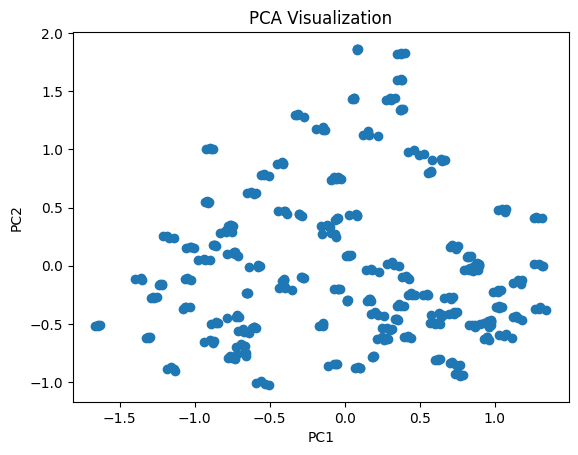

In [4]:
# 1.3 Dimensionality Reduction

# Apply PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(preprocessed_df)
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

#plot PCA
import matplotlib.pyplot as plt
plt.scatter(pca_df['PC1'], pca_df['PC2'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Visualization')
plt.show()



In [5]:

def create_time_based_features(combined_df, utterances_df, exercises_df):
    # Days since last practice
    last_practice = exercises_df.groupby('user_id')['timestamp'].max().reset_index()
    last_practice['days_since_last_practice'] = (pd.to_datetime('now') - pd.to_datetime(last_practice['timestamp'])).dt.days
    combined_df = combined_df.merge(last_practice[['user_id', 'days_since_last_practice']], on='user_id', how='left')
    
    # Weekly improvement rate
    exercises_df['timestamp'] = pd.to_datetime(exercises_df['timestamp'])  # Ensure timestamp is datetime
    weekly_scores = exercises_df.set_index('timestamp').groupby('user_id').resample('W')['performance_score'].mean().reset_index()
    weekly_scores['improvement_rate'] = weekly_scores.groupby('user_id')['performance_score'].pct_change()
    weekly_improvement = weekly_scores.groupby('user_id')['improvement_rate'].mean().reset_index()
    combined_df = combined_df.merge(weekly_improvement, on='user_id', how='left')
    
    return combined_df

combined_df = create_time_based_features(combined_df, utterances_df, exercises_df)

combined_df.columns

C:\Users\HP\AppData\Local\Temp\ipykernel_21980\3254878504.py:10: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  weekly_scores['improvement_rate'] = weekly_scores.groupby('user_id')['performance_score'].pct_change()


Index(['user_id', 'country', 'age_band', 'proficiency_level', 'interests',
       'cefr_level', 'overall_progress', 'total_practice_time',
       'exercises_completed', 'daily_active_days', 'weekly_active_days',
       'total_sessions', 'avg_session_duration', 'current_focus',
       'adaptive_difficulty', 'personalized_goals', 'engagement_score_x',
       'grammar_overall_score', 'vocabulary_overall_score',
       'pronunciation_overall_score', 'fluency_overall_score',
       'error_freq_fluency', 'error_freq_grammar', 'error_freq_pronunciation',
       'error_freq_vocabulary', 'performance_score', 'timestamp',
       'recent_grammar_errors', 'vocab_improvement', 'fluency_trend',
       'engagement_score_y', 'error_freq_a_c', 'error_freq_a_r',
       'error_freq_c_o', 'error_freq_c_o', 'error_freq_c_o', 'error_freq_f_i',
       'error_freq_i_d', 'error_freq_i_n', 'error_freq_p_a', 'error_freq_p_r',
       'error_freq_s_p', 'error_freq_s_u', 'error_freq_t_e', 'error_freq_v_o',
       '

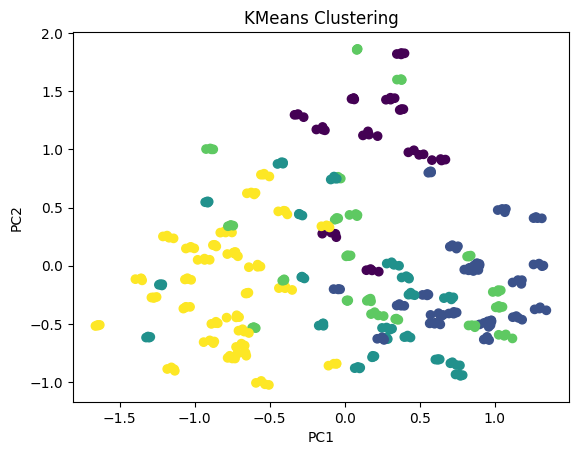

In [6]:
# 2. User Profiling and Clustering

# 2.1 Clustering Algorithm-CAN HAVE BETTER ALGORITHM HERE DEPENDING ON REAL DATA
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(preprocessed_df)
combined_df['cluster'] = cluster_labels

combined_df['cluster']

#Plotting the clusters
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=combined_df['cluster'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('KMeans Clustering')
plt.show()



In [7]:

# # Feature selection
# selector = SelectKBest(score_func=f_regression, k=20)
# selected_features = selector.fit_transform(preprocessed_df, combined_df['overall_progress'])
# selected_feature_names = preprocessed_df.columns[selector.get_support()].tolist()

In [8]:
# # 2.2 Dynamic User Profiling

# class DynamicUserProfile:
#     def __init__(self, user_id):
#         self.user_id = user_id
#         self.profile = {}
#         self.drift_detectors = {}
        
#     def update(self, new_data):
#         for feature, value in new_data.items():
#             if feature not in self.profile:
#                 self.profile[feature] = value
#                 self.drift_detectors[feature] = drift.ADWIN()
#             else:
#                 self.profile[feature] = 0.9 * self.profile[feature] + 0.1 * value
#                 drift_detected = self.drift_detectors[feature].update(value)
#                 if drift_detected:
#                     print(f"Concept drift detected for user {self.user_id} in feature {feature}")
                    
#     def get_profile(self):
#         return self.profile

# # Example usage of DynamicUserProfile
# user_profiles = {user_id: DynamicUserProfile(user_id) for user_id in combined_df['user_id']}

# # Simulate updating user profiles with new data
# for _, row in combined_df.iterrows():
#     user_id = row['user_id']
#     new_data = row[selected_feature_names].to_dict()
#     user_profiles[user_id].update(new_data)

# # Print sample user profile
# sample_user_id = combined_df['user_id'].iloc[0]
# print(f"Sample user profile for user {sample_user_id}:")
# print(user_profiles[sample_user_id].get_profile())

# 3. Exercise Category Selection-VANILA IMPLEMENTATION


Results for Thompson Sampling MAB:
Average reward per category:
chosen_category
0    0.761594
1    0.736670
2    0.785438
3    0.742692
Name: reward, dtype: float64

Category selection frequency:
chosen_category
2    0.5262
0    0.3629
1    0.0608
3    0.0501
Name: proportion, dtype: float64

Results for LinUCB:
Average reward per category:
chosen_category
0    0.721305
1    0.730181
2    0.795573
3    0.863520
Name: reward, dtype: float64

Category selection frequency:
chosen_category
2    0.4087
1    0.2593
3    0.1721
0    0.1599
Name: proportion, dtype: float64


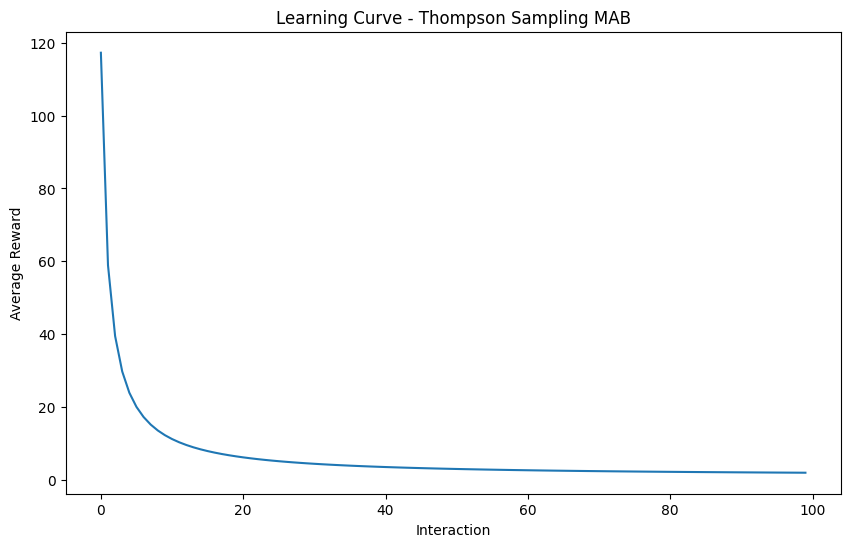

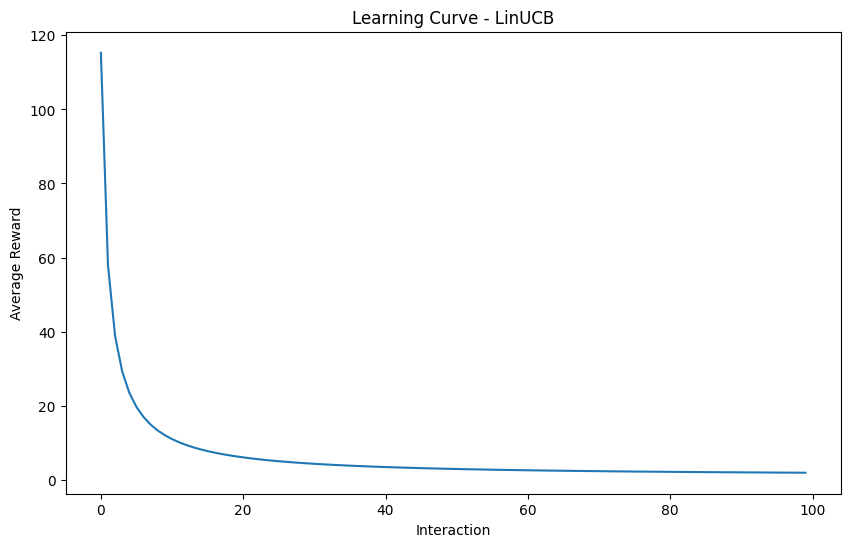


Sample exercise recommendation:
Chosen category: Vocabulary
Recommended difficulty: 0.48

Generated exercise:
{
  "category": "Vocabulary",
  "type": "speaking_practice",
  "difficulty": 0.4827232504843406,
  "content": "This is a 0.48 difficulty Vocabulary exercise for user interest: technology"
}


C:\Users\HP\AppData\Local\Temp\ipykernel_21980\2843764989.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_data['engagement_score'] = np.random.rand()
C:\Users\HP\AppData\Local\Temp\ipykernel_21980\2843764989.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_data['engagement_score'] = np.random.rand()


In [9]:
import numpy as np
import pandas as pd
import json
from scipy.stats import beta
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

class ThompsonSamplingMAB:
    def __init__(self, n_arms):
        self.n_arms = n_arms
        self.alpha = np.ones(n_arms)
        self.beta = np.ones(n_arms)
    
    def select_arm(self):
        return np.argmax(beta.rvs(self.alpha, self.beta))
    
    def update(self, chosen_arm, reward):
        self.alpha[chosen_arm] += reward
        self.beta[chosen_arm] += 1 - reward

class LinUCB:
    def __init__(self, n_arms, n_features, alpha):
        self.n_arms = n_arms
        self.n_features = n_features
        self.alpha = alpha
        
        self.A = [np.identity(n_features) for _ in range(n_arms)]
        self.b = [np.zeros((n_features, 1)) for _ in range(n_arms)]
        self.theta = [np.zeros((n_features, 1)) for _ in range(n_arms)]

    def select_arm(self, context):
        ucb_values = []
        for arm in range(self.n_arms):
            theta = np.linalg.inv(self.A[arm]).dot(self.b[arm])
            self.theta[arm] = theta
            
            ucb = theta.T.dot(context) + self.alpha * np.sqrt(context.T.dot(np.linalg.inv(self.A[arm])).dot(context))
            ucb_values.append(ucb[0][0])
        
        return np.argmax(ucb_values)

    def update(self, chosen_arm, context, reward):
        self.A[chosen_arm] += context.dot(context.T)
        self.b[chosen_arm] += reward * context

def simulate_user_interaction(user_data, n_interactions=100):
    # Simulating user performance improvement
    base_performance = np.random.rand(4)  # Initial performance for each category
    improvement_rate = np.random.rand(4) * 0.01  # Random improvement rate for each category

    if 'engagement_score' not in user_data:
        user_data['engagement_score'] = np.random.rand()
        
    
    for _ in range(n_interactions):
        context = np.array([
            user_data['grammar_overall_score'],
            user_data['vocabulary_overall_score'],
            user_data['pronunciation_overall_score'],
            user_data['fluency_overall_score'],
            user_data['engagement_score']
        ]).reshape(-1, 1)
        
        yield context, base_performance
        
        # Simulate improvement
        base_performance += improvement_rate
        base_performance = np.clip(base_performance, 0, 1)

def run_experiment(users_df, algorithm, n_users=100, n_interactions=100):
    results = []
    
    for _, user in users_df.head(n_users).iterrows():
        user_simulator = simulate_user_interaction(user, n_interactions)
        
        for t in range(n_interactions):
            context, true_performance = next(user_simulator)
            
            if isinstance(algorithm, ThompsonSamplingMAB):
                chosen_arm = algorithm.select_arm()
                reward = true_performance[chosen_arm]
                algorithm.update(chosen_arm, reward)
            elif isinstance(algorithm, LinUCB):
                chosen_arm = algorithm.select_arm(context)
                reward = true_performance[chosen_arm]
                algorithm.update(chosen_arm, context, reward)
            
            results.append({
                'user_id': user['user_id'],
                'interaction': t,
                'chosen_category': chosen_arm,
                'reward': reward
            })
    
    return pd.DataFrame(results)

# Initialize and run experiments
n_categories = 4  # Grammar, Vocabulary, Pronunciation, Fluency
n_features = 5  # 4 category scores + engagement score

thompson_mab = ThompsonSamplingMAB(n_categories)
linucb = LinUCB(n_categories, n_features, alpha=1.0)

thompson_results = run_experiment(combined_df, thompson_mab)
linucb_results = run_experiment(combined_df, linucb)

# Analyze results
def analyze_results(results, algorithm_name):
    print(f"\nResults for {algorithm_name}:")
    print("Average reward per category:")
    print(results.groupby('chosen_category')['reward'].mean())
    print("\nCategory selection frequency:")
    print(results['chosen_category'].value_counts(normalize=True))

analyze_results(thompson_results, "Thompson Sampling MAB")
analyze_results(linucb_results, "LinUCB")

# Visualize learning progress
import matplotlib.pyplot as plt

def plot_learning_curve(results, algorithm_name):
    plt.figure(figsize=(10, 6))
    results['cumulative_reward'] = results.groupby('user_id')['reward'].cumsum()
    results['average_reward'] = results['cumulative_reward'] / (results['interaction'] + 1)
    
    avg_performance = results.groupby('interaction')['average_reward'].mean()
    plt.plot(avg_performance.index, avg_performance.values)
    
    plt.title(f"Learning Curve - {algorithm_name}")
    plt.xlabel("Interaction")
    plt.ylabel("Average Reward")
    plt.show()

plot_learning_curve(thompson_results, "Thompson Sampling MAB")
plot_learning_curve(linucb_results, "LinUCB")

# Implement a simple policy for exercise difficulty selection
def select_exercise_difficulty(user_performance, category):
    base_difficulty = 0.5  # Start with medium difficulty
    adaptation_rate = 0.1  # How quickly to adapt difficulty
    
    # Adjust difficulty based on user's performance in the chosen category
    adjusted_difficulty = base_difficulty + adaptation_rate * (user_performance[category] - 0.5)
    
    # Ensure difficulty is between 0 and 1
    return np.clip(adjusted_difficulty, 0, 1)

# Example usage
sample_user = combined_df.iloc[0]
sample_context, sample_performance = next(simulate_user_interaction(sample_user))
chosen_category = linucb.select_arm(sample_context)
difficulty = select_exercise_difficulty(sample_performance, chosen_category)

print(f"\nSample exercise recommendation:")
print(f"Chosen category: {['Grammar', 'Vocabulary', 'Pronunciation', 'Fluency'][chosen_category]}")
print(f"Recommended difficulty: {difficulty:.2f}")

# Function to generate exercise content based on user profile and chosen category
def generate_exercise_content(user_profile, category, difficulty):
    # This is a placeholder function. In a real system, this would be much more complex
    # and would likely involve NLP techniques, content databases, etc.
    categories = ['Grammar', 'Vocabulary', 'Pronunciation', 'Fluency']
    exercise_types = ['multiple_choice', 'fill_in_blanks', 'speaking_practice', 'writing_prompt']
    
    exercise = {
        'category': categories[category],
        'type': np.random.choice(exercise_types),
        'difficulty': difficulty,
        'content': f"This is a {difficulty:.2f} difficulty {categories[category]} exercise for user interest: {np.random.choice(user_profile['interests'])}"
    }
    
    return exercise

# Example usage of exercise generation
sample_user_profile = {
    'interests': ['technology', 'travel'],
    'country': 'Japan',
    'age_band': '25-34'
}

generated_exercise = generate_exercise_content(sample_user_profile, chosen_category, difficulty)
print("\nGenerated exercise:")
print(json.dumps(generated_exercise, indent=2))